# Case Study Analysis Notebook

The purpose of this code is to understand why the Flagstaff Depth to Water graphs indicate massive declines but not the individual wells.  It clips wells from a shapefile and creates a timeseries of wells by depth.  It is a combination of many of the other notebooks consolidated into this one.

The conclusion was that wells drilled deeper in more recent years are skewing our spatial averages of depth to water.

To run this code, you need the following files in the appropriate folders
 - Data/Input
   > Master_ADWR_database_noduplicates.shp
   > Master_ADWR_database_water.shp
   > Yearly_DroughtIndices_updated[your date here].csv
 - Data/Output
   > Wells55_GWSI_WLTS_DB_annual_updated_thresh15outliersdeleted.csv
 - Data/Shapefiles
   > Any shapefiles of your choosing

In [3]:
# Packages and paths
# %%
from optparse import Values
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.colors import ListedColormap
import datetime
from matplotlib.transforms import Bbox
import numpy as np
import pandas as pd
from shapely.geometry import box
import geopandas as gp
#import earthpy as et
import scipy.stats as sp
from scipy.stats import kendalltau, pearsonr, spearmanr
import pymannkendall as mk
import sys

# Add the path to the Utils folder
utils_path = os.path.abspath(os.path.join('..', 'Utils'))
if utils_path not in sys.path:
    sys.path.append(utils_path)

# Now you can import the functions from CustomFunctions.py
import CustomFunctions as cf

# Local paths
datapath = '../../Data'
inputpath = '../../Data/Input'
outputpath = '../../Data/Output/Local'
shapepath = inputpath+'/Shapefiles'
figurepath = '../../Figures/'

In [4]:
# %% Creating colors
c_1 = '#8d5a99' # Reservation
c_2 = "#d7191c" # Regulated with CAP (Water Category Color)
c_3 = '#e77a47' # Regulated without CAP (Water Category Color)
c_4 = '#2cbe21' # Lower CO River - SW (Water Category Color)
c_5 = '#2f8c73' # Upper CO River - Mixed (Water Category Color)
c_6 = '#6db7e8' # SE - GW
c_7 = '#165782' # NW - GW (Water Category color)
c_8 = '#229ce8' # SC - GW
c_9 = '#1f78b4' # NE - GW
c_10 = '#41bf9e' # N - Mixed
c_11 = '#7adec4' # C - Mixed
drought_color = '#ffa6b8'
wet_color = '#b8d3f2'

reg_colors = [c_2,c_7]
georeg_colors = [c_1,c_2,c_3,c_4,c_5,c_6,c_7,c_8,c_9,c_10,c_11]
SW_colors = [c_2,c_3,c_4,c_5,c_7]

bar_watercatc = [c_2,c_3,c_4,c_5,c_7]


# Color blind palette
# https://jacksonlab.agronomy.wisc.edu/2016/05/23/15-level-colorblind-friendly-palette/
blind =["#000000","#004949","#009292","#ff6db6","#ffb6db",
 "#490092","#006ddb","#b66dff","#6db6ff","#b6dbff",
 "#920000","#924900","#db6d00","#24ff24","#ffff6d"]

# Matching new map

grace_color = '#A92B2A'
az_wells_color = '#1D4E77'

cap = '#77A8A5' #'#C6652B'
cap_secondary = '#004D40'
# noCAP = '#EDE461' # This is one from the map
noCAP = '#CCC339' # This color but darker for lines
GWdom = '#3B76AF'
mixed = '#6EB2E4'
swdom = '#469B76'

In [5]:
# %% Drought dictionary
DROUGHT_YEARS = {
        # 1:[1989,1990]
        # ,2:[1996]
        3:[2002,2003]
        ,4:[2006,2007]
        ,5:[2012,2013,2014]
        ,6:[2018]
        ,7:[2021]}

print(DROUGHT_YEARS)

{3: [2002, 2003], 4: [2006, 2007], 5: [2012, 2013, 2014], 6: [2018], 7: [2021]}


In [6]:
#%% Pre-drought
# PREDROUGHT_YEARS = {1:[1988]
#         ,2:[1995]
#         ,3:[2001]
#         ,4:[2005]
#         ,5:[2011]
#         ,6:[2017]}

PREDROUGHT_YEARS = {1:[*range(1975,1988,1)]
        ,2:[*range(1991,1995,1)]
        ,3:[*range(1997,2001,1)]
        ,4:[*range(2004,2005,1)]
        ,5:[*range(2006,2011,1)]
        ,6:[*range(2015,2017,1)]}

print(PREDROUGHT_YEARS)

{1: [1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987], 2: [1991, 1992, 1993, 1994], 3: [1997, 1998, 1999, 2000], 4: [2004], 5: [2006, 2007, 2008, 2009, 2010], 6: [2015, 2016]}


Read in the main databases.  You only have to do this once.

Master Database might take a while (~5-7 minutes).

In [7]:
# Read in the main Static Database

filename_mdb_nd = 'Master_ADWR_database_noduplicates.shp'
filepath = os.path.join(inputpath_local, filename_mdb_nd)
print(filepath)

masterdb = gp.read_file(filepath)
pd.options.display.float_format = '{:.2f}'.format
print(masterdb.info())

../Data/Input_files\Master_ADWR_database_noduplicates.shp
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 250870 entries, 0 to 250869
Data columns (total 72 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   Combo_ID    250870 non-null  object  
 1   SITE_ID     45565 non-null   object  
 2   LOCAL_ID    45565 non-null   object  
 3   REGISTRY_I  229717 non-null  object  
 4   WELL_TYPE   45565 non-null   object  
 5   DD_LAT      45565 non-null   float64 
 6   DD_LONG     45565 non-null   float64 
 7   WELL_ALT    45565 non-null   float64 
 8   WATER_USE_  45507 non-null   object  
 9   WELL_DEPTH  221075 non-null  float64 
 10  CASE_DIAM   45565 non-null   float64 
 11  LASTWLDATE  34356 non-null   object  
 12  WL_DTW      45565 non-null   float64 
 13  WL_ELEV     45565 non-null   float64 
 14  QUASI_IDX_  11 non-null      object  
 15  GOES_ENABL  171 non-null     object  
 16  TRANSDUCER  171 non-null     object  
 17  I

This one takes about 3-4 minutes to run

In [8]:
# Read in the database of number water wells
filename_mdb_w = 'Master_ADWR_database_water.shp'
filepath = os.path.join(inputpath_local, filename_mdb_w)
print(filepath)

masterdb_water = gp.read_file(filepath)
pd.options.display.float_format = '{:.2f}'.format
print(masterdb_water.info())

../Data/Input_files\Master_ADWR_database_water.shp
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 140185 entries, 0 to 140184
Data columns (total 72 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   Combo_ID    140185 non-null  object  
 1   SITE_ID     45565 non-null   object  
 2   LOCAL_ID    45565 non-null   object  
 3   REGISTRY_I  119032 non-null  object  
 4   WELL_TYPE   45565 non-null   object  
 5   DD_LAT      45565 non-null   float64 
 6   DD_LONG     45565 non-null   float64 
 7   WELL_ALT    45565 non-null   float64 
 8   WATER_USE_  45507 non-null   object  
 9   WELL_DEPTH  139606 non-null  float64 
 10  CASE_DIAM   45565 non-null   float64 
 11  LASTWLDATE  34356 non-null   object  
 12  WL_DTW      45565 non-null   float64 
 13  WL_ELEV     45565 non-null   float64 
 14  QUASI_IDX_  11 non-null      object  
 15  GOES_ENABL  171 non-null     object  
 16  TRANSDUCER  171 non-null     object  
 17  IDXBK2  

In [9]:
# Read in the annual time series database
# This file was created in Well_Timeseries_merge.py

filename_ts = 'Wells55_GWSI_WLTS_DB_annual_updated_thresh15outliersdeleted.csv'
filepath = os.path.join(outputpath_local, filename_ts)
print(filepath)
annual_db = pd.read_csv(filepath, header=1, index_col=0)

#Block to do some formatting
annual_db = annual_db[1:168102]
annual_db.index = annual_db.index.astype('int64')
annual_db2 = annual_db.reset_index(inplace=True)
annual_db2 = annual_db.rename(columns = {'year':'Combo_ID'})
annual_db2.head()

../Data/Output_files/Wells55_GWSI_WLTS_DB_annual_updated_thresh15outliersdeleted.csv


,Combo_ID,1853.0,1856.0,1857.0,1860.0,1864.0,1868.0,1870.0,1871.0,1872.0,...,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0,2020.0,2021.0,2022.0,2023.0
0,60001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,503.90,497.70,495.30,NaN,489.85,NaN,487.85,485.10,483.50,NaN
1,85358,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,264.73,NaN,262.43,254.88,251.65,251.53,NaN,NaN,NaN,NaN
2,85761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,44.90,44.70,45.50,45.30,46.30,45.00,46.20,43.50,NaN,NaN
3,85799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,58.90,59.30,59.80,57.80,59.50,60.10,59.40,60.80,62.10,NaN
4,85863,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,112.64,114.74,115.50,116.26,117.10,119.34,118.49,119.77,120.65,118.66


### From here down is where you can rerun the code to generate graphs

<Axes: >

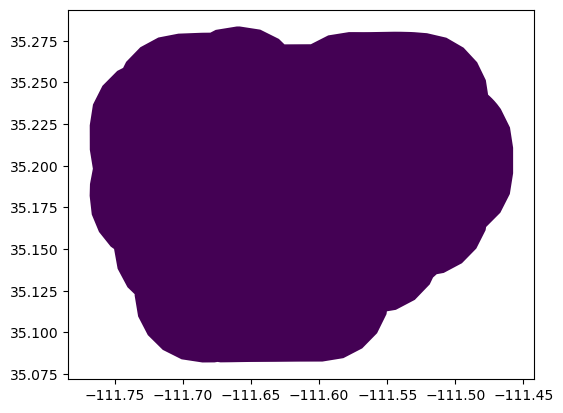

In [10]:
# Read in the shapefile

# filename_shapeile = 'georeg_reproject_fixed.shp'
filename_shapeile = 'Flagstaff_buffered.shp'
filepath = os.path.join(shapepath_local, filename_shapeile)
shapefile = gp.read_file(filepath)
shapefile.plot(cmap='viridis')


In [11]:
shapefile

,Name,FID,AMA_CODE,SUBBASIN_N,NAME_ABBR,SUBBASIN_1,SHAPEAREA,layer,path,geometry
0,Flagstaff,14,NaN,NaN,NaN,NaN,NaN,Flagstaff_Buffered,/Users/danielletadych/Documents/PhD_Materials/...,"POLYGON Z ((-111.76613 35.19826 0.00000, -111...."


In [12]:
# Define some things about your file

StudyArea = "Flagstaff_0352024"
Naming_col = "Name"
# Naming_col = "SUBBASIN_N"
water_designation = GWdom 

Merging the databases takes a little time - Approximately 3 minutes

In [13]:
# Merge the shapefile with the master database

shapefile = shapefile.to_crs(epsg=26912)
masterdb2 = masterdb.set_crs(epsg=26912)
masterdb_water = masterdb_water.set_crs(epsg=26912)
# For main static database
static_geo = gp.sjoin(masterdb2, shapefile, how="inner", op='intersects')

print(str(filename_mdb_nd) + " and " + str(filename_shapeile) + " join complete.")

# %% For the water wells water wells
static_geo2 = gp.sjoin(masterdb_water, shapefile, how="inner", op='intersects')
static_geo2.head()
print(str(filename_mdb_nd) + " and " + str(filename_shapeile) + " join complete.")


c:\Users\det19\.conda\envs\azgwspatialanalysis\lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Master_ADWR_database_noduplicates.shp and Flagstaff_buffered.shp join complete.


c:\Users\det19\.conda\envs\azgwspatialanalysis\lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Master_ADWR_database_noduplicates.shp and Flagstaff_buffered.shp join complete.


In [14]:
static_geo

,Combo_ID,SITE_ID,LOCAL_ID,REGISTRY_I,WELL_TYPE,DD_LAT,DD_LONG,WELL_ALT,WATER_USE_,WELL_DEPTH,...,index_right,Name,FID,AMA_CODE,SUBBASIN_N_right,NAME_ABBR,SUBBASIN_1,SHAPEAREA,layer,path
666,085704,NaN,NaN,085704,NaN,NaN,NaN,NaN,NaN,0.00,...,0,Flagstaff,14,NaN,NaN,NaN,NaN,NaN,Flagstaff_Buffered,/Users/danielletadych/Documents/PhD_Materials/...
2516,087825,NaN,NaN,087825,NaN,NaN,NaN,NaN,NaN,158.00,...,0,Flagstaff,14,NaN,NaN,NaN,NaN,NaN,Flagstaff_Buffered,/Users/danielletadych/Documents/PhD_Materials/...
2721,200199,NaN,NaN,200199,NaN,NaN,NaN,NaN,NaN,NaN,...,0,Flagstaff,14,NaN,NaN,NaN,NaN,NaN,Flagstaff_Buffered,/Users/danielletadych/Documents/PhD_Materials/...
2838,200318,NaN,NaN,200318,NaN,NaN,NaN,NaN,NaN,220.00,...,0,Flagstaff,14,NaN,NaN,NaN,NaN,NaN,Flagstaff_Buffered,/Users/danielletadych/Documents/PhD_Materials/...
3122,200610,NaN,NaN,200610,NaN,NaN,NaN,NaN,NaN,197.00,...,0,Flagstaff,14,NaN,NaN,NaN,NaN,NaN,Flagstaff_Buffered,/Users/danielletadych/Documents/PhD_Materials/...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249633,928408,NaN,NaN,928408,NaN,NaN,NaN,NaN,NaN,220.00,...,0,Flagstaff,14,NaN,NaN,NaN,NaN,NaN,Flagstaff_Buffered,/Users/danielletadych/Documents/PhD_Materials/...
249838,928615,NaN,NaN,928615,NaN,NaN,NaN,NaN,NaN,240.00,...,0,Flagstaff,14,NaN,NaN,NaN,NaN,NaN,Flagstaff_Buffered,/Users/danielletadych/Documents/PhD_Materials/...
250184,928969,NaN,NaN,928969,NaN,NaN,NaN,NaN,NaN,280.00,...,0,Flagstaff,14,NaN,NaN,NaN,NaN,NaN,Flagstaff_Buffered,/Users/danielletadych/Documents/PhD_Materials/...
250831,929636,NaN,NaN,929636,NaN,NaN,NaN,NaN,NaN,NaN,...,0,Flagstaff,14,NaN,NaN,NaN,NaN,NaN,Flagstaff_Buffered,/Users/danielletadych/Documents/PhD_Materials/...


In [15]:
# Pull out the columns you need
# Use this or subbasins:
# reg_list = static_geo[['Combo_ID', Naming_col+'_right','WELL_DEPTH','WELL_TYPE_']]
# Use this or cities:
reg_list = static_geo[['Combo_ID', Naming_col,'WELL_DEPTH','WELL_TYPE_']]
# reg_list

# %% Converting Combo_ID to int
reg_list['Combo_ID'] = reg_list['Combo_ID'].astype(np.int64, errors = 'raise')

C:\Users\det19\AppData\Local\Temp\ipykernel_24176\1936538389.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reg_list['Combo_ID'] = reg_list['Combo_ID'].astype(np.int64, errors = 'raise')


In [16]:
# Merging the Timeseries and the shapefile static database
combo = annual_db2.merge(reg_list, how="inner")
combo.info()

# %% set index to Combo_ID
combo.set_index('Combo_ID', inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Columns: 163 entries, Combo_ID to WELL_TYPE_
dtypes: float64(160), int64(1), object(2)
memory usage: 11.6+ KB


Doing some Q/A to figure out what's going on with these wells and why the slopes are different than the spatial average

In [31]:
test = combo.copy()
test = test.drop(['WELL_DEPTH','WELL_TYPE_','Name'],axis=1)
test

,1853.0,1856.0,1857.0,1860.0,1864.0,1868.0,1870.0,1871.0,1872.0,1873.0,...,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0,2020.0,2021.0,2022.0,2023.0
Combo_ID,,,,,,,,,,,,,,,,,,,,,
509491,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,123.10,123.40,123.67,123.85,124.55,NaN,NaN,NaN,NaN,NaN
559571,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,926.74,926.66,926.66,926.68,927.15,927.23,927.47,927.48,927.46,NaN
600511,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,168.95,171.80,188.20,164.45,NaN,NaN,NaN,NaN,NaN,NaN
608396,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,73.83,74.07,78.87,67.20,73.20,68.70,73.03,76.17,77.65,77.20
637392,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1310.80,1310.40,1311.57,1311.13,1309.92,1310.10,1309.80,1310.03,1309.65,1309.00
644021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,124.80,125.13,124.77,119.35,120.42,121.67,120.88,127.17,125.05,NaN
647022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,51.77,50.73,52.37,51.08,56.58,48.27,53.90,53.08,46.93,52.10
808126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,113.30,104.50,120.80,79.90,135.00,80.10,80.80,79.80,NaN,NaN
351556111430401,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,186.45,185.67,185.60,185.15,183.62,185.07,184.53,185.38,184.82,183.70


In [32]:
# Clean up the dataframe for graphing
test = test.copy()
i = test
# del i['WELL_DEPTH']
f = i.transpose()
f.reset_index(inplace=True)
f['index'] = pd.to_numeric(f['index'])
f['index'] = f['index'].astype(int)
f.set_index('index', inplace=True)
f.info()
test = f
test

<class 'pandas.core.frame.DataFrame'>
Index: 159 entries, 1853 to 2023
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   509491           31 non-null     float64
 1   559571           27 non-null     float64
 2   600511           30 non-null     float64
 3   608396           34 non-null     float64
 4   637392           19 non-null     float64
 5   644021           35 non-null     float64
 6   647022           36 non-null     float64
 7   808126           49 non-null     float64
 8   351556111430401  35 non-null     float64
dtypes: float64(9)
memory usage: 11.8 KB


Combo_ID,509491,559571,600511,608396,637392,644021,647022,808126,351556111430401
index,,,,,,,,,
1853,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1856,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1857,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1860,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1864,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2019,NaN,927.23,NaN,68.70,1310.10,121.67,48.27,80.10,185.07
2020,NaN,927.47,NaN,73.03,1309.80,120.88,53.90,80.80,184.53
2021,NaN,927.48,NaN,76.17,1310.03,127.17,53.08,79.80,185.38


<Axes: xlabel='index'>

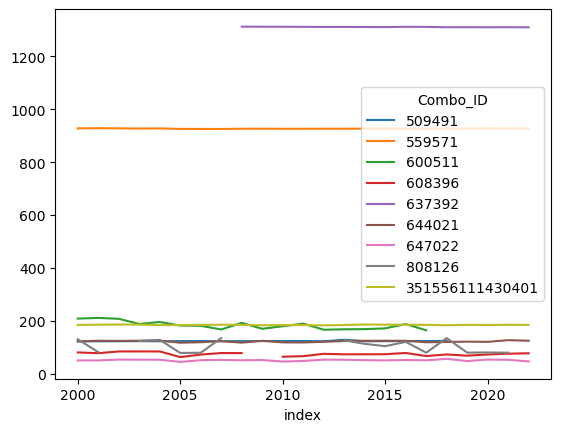

In [34]:
Min_year_of_Study = 2000
test_plotting = test[(test.index>=Min_year_of_Study)&(test.index<=2022)]
test_plotting.plot()

Checked the Combo_ID's of 559671 and 637392 and found out
1) they are both drilled into a deeper aquifer (1800 feet depth!)
2) they are both transducer wells
3) all other wells are shallow

I think the best thing then would be to group by Shallow and Deep

In [17]:
# Create a function to apply the criteria
def categorize_depth(depth):
    if depth < 200:
        return "Shallow"
    elif 200 <= depth <= 500:
        return "Midrange"
    else:
        return "Deep"

# Apply the function to create a new column
combo['Depth_Category'] = combo['WELL_DEPTH'].apply(categorize_depth)
combo

,1853.0,1856.0,1857.0,1860.0,1864.0,1868.0,1870.0,1871.0,1872.0,1873.0,...,2018.0,2019.0,2020.0,2021.0,2022.0,2023.0,Name,WELL_DEPTH,WELL_TYPE_,Depth_Category
Combo_ID,,,,,,,,,,,,,,,,,,,,,
509491,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,124.55,NaN,NaN,NaN,NaN,NaN,Flagstaff,155.00,EXEMPT,Shallow
559571,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,927.15,927.23,927.47,927.48,927.46,NaN,Flagstaff,1800.00,NON-EXEMPT,Deep
600511,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Flagstaff,320.00,EXEMPT,Midrange
608396,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,73.20,68.70,73.03,76.17,77.65,77.20,Flagstaff,86.00,NON-EXEMPT,Shallow
637392,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1309.92,1310.10,1309.80,1310.03,1309.65,1309.00,Flagstaff,1800.00,EXEMPT,Deep
644021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,120.42,121.67,120.88,127.17,125.05,NaN,Flagstaff,150.00,EXEMPT,Shallow
647022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,56.58,48.27,53.90,53.08,46.93,52.10,Flagstaff,60.00,EXEMPT,Shallow
808126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,135.00,80.10,80.80,79.80,NaN,NaN,Flagstaff,140.00,EXEMPT,Shallow
351556111430401,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,183.62,185.07,184.53,185.38,184.82,183.70,Flagstaff,268.00,NaN,Midrange


In [18]:
# Grouping the appropriate column
combo_copy = combo.copy()
combo_copy = combo_copy.drop(['WELL_DEPTH','WELL_TYPE_','Name'],axis=1)
# cat_wl = combo_copy.groupby([Naming_col+"_right"]).mean()
cat_wl = combo_copy.groupby(['Depth_Category']).mean()

In [19]:
# Clean up the dataframe for graphing
cat_wl2 = cat_wl.copy()
i = cat_wl2
# del i['WELL_DEPTH']
f = i.transpose()
f.reset_index(inplace=True)
f['index'] = pd.to_numeric(f['index'])
f['index'] = f['index'].astype(int)
f.set_index('index', inplace=True)
f.info()
cat_wl2 = f
cat_wl2

<class 'pandas.core.frame.DataFrame'>
Index: 159 entries, 1853 to 2023
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Deep      30 non-null     float64
 1   Midrange  36 non-null     float64
 2   Shallow   56 non-null     float64
dtypes: float64(3)
memory usage: 4.3 KB


Depth_Category,Deep,Midrange,Shallow
index,,,
1853,NaN,NaN,NaN
1856,NaN,NaN,NaN
1857,NaN,NaN,NaN
1860,NaN,NaN,NaN
1864,NaN,NaN,NaN
...,...,...,...
2019,1118.66,185.07,79.69
2020,1118.63,184.53,82.15
2021,1118.75,185.38,84.06


In [20]:
cat_wl2.head(-1)

Depth_Category,Deep,Midrange,Shallow
index,,,
1853,NaN,NaN,NaN
1856,NaN,NaN,NaN
1857,NaN,NaN,NaN
1860,NaN,NaN,NaN
1864,NaN,NaN,NaN
...,...,...,...
2018,1118.54,183.62,101.95
2019,1118.66,185.07,79.69
2020,1118.63,184.53,82.15


In [21]:
# Export the dataframe
# cat_wl2_reg.to_csv(outputpath_local+'Waterlevels_Regulation_updated_thresh15outliersdeleted.csv')

### Analysis and Graphing

In [22]:
# Read in the drought indices
# drought_indices = pd.read_csv(datapath+'Yearly_DroughtIndices.csv')
drought_indices = pd.read_csv(inputpath_local+'/Yearly_DroughtIndices_updated12032023.csv') #this version doesn't have PHDI so adjust accordingly
drought_indices = drought_indices.set_index('In_year')
# drought_indices

In [23]:
Min_year_of_Study = 2000

# Water Analysis period
wlanalysis_period = cat_wl2[(cat_wl2.index>=Min_year_of_Study)&(cat_wl2.index<=2022)]
drought_indices = drought_indices[(drought_indices.index>=Min_year_of_Study)&(drought_indices.index<=2022)]
# del wlanalysis_period['Res'] # Only run this if doing regulation shapefile
wlanalysis_period.head()

Depth_Category,Deep,Midrange,Shallow
index,,,
2000,927.83,196.81,101.54
2001,1121.69,198.63,91.73
2002,927.85,197.11,96.48
2003,927.07,187.34,102.23
2004,927.50,190.06,103.03


This is helpful if you're missing values and it won't calculate statistics

In [24]:
df_interpolated = wlanalysis_period.interpolate(method='linear', axis=0)
df_interpolated

Depth_Category,Deep,Midrange,Shallow
index,,,
2000,927.83,196.81,101.54
2001,1121.69,198.63,91.73
2002,927.85,197.11,96.48
2003,927.07,187.34,102.23
2004,927.50,190.06,103.03
2005,925.60,183.39,85.68
2006,925.52,183.07,89.51
2007,925.40,176.68,102.69
2008,1119.26,188.93,92.76


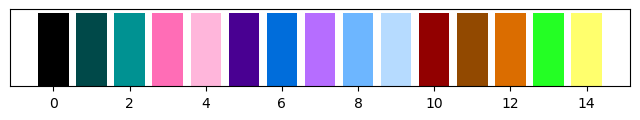

In [28]:
# Create a bar plot to visualize colors
fig, ax = plt.subplots(figsize=(8, 1))
ax.bar(range(len(blind)), height=1, color=blind)

# Remove y-axis
ax.set_yticks([])

# Show the plot
plt.show()

In [31]:
color_list = [blind[0],blind[1],blind[2]]

             Deep  Midrange  Shallow
slope        9.44     -0.50    -0.54
int     -17924.18   1191.71  1170.51
rsq          0.50      0.24     0.22
p_val        0.00      0.02     0.02
std_err      2.06      0.19     0.22
mean      1060.45    184.39    93.68
var       7829.58     45.33    56.22
sum      24390.39   4240.87  2154.60


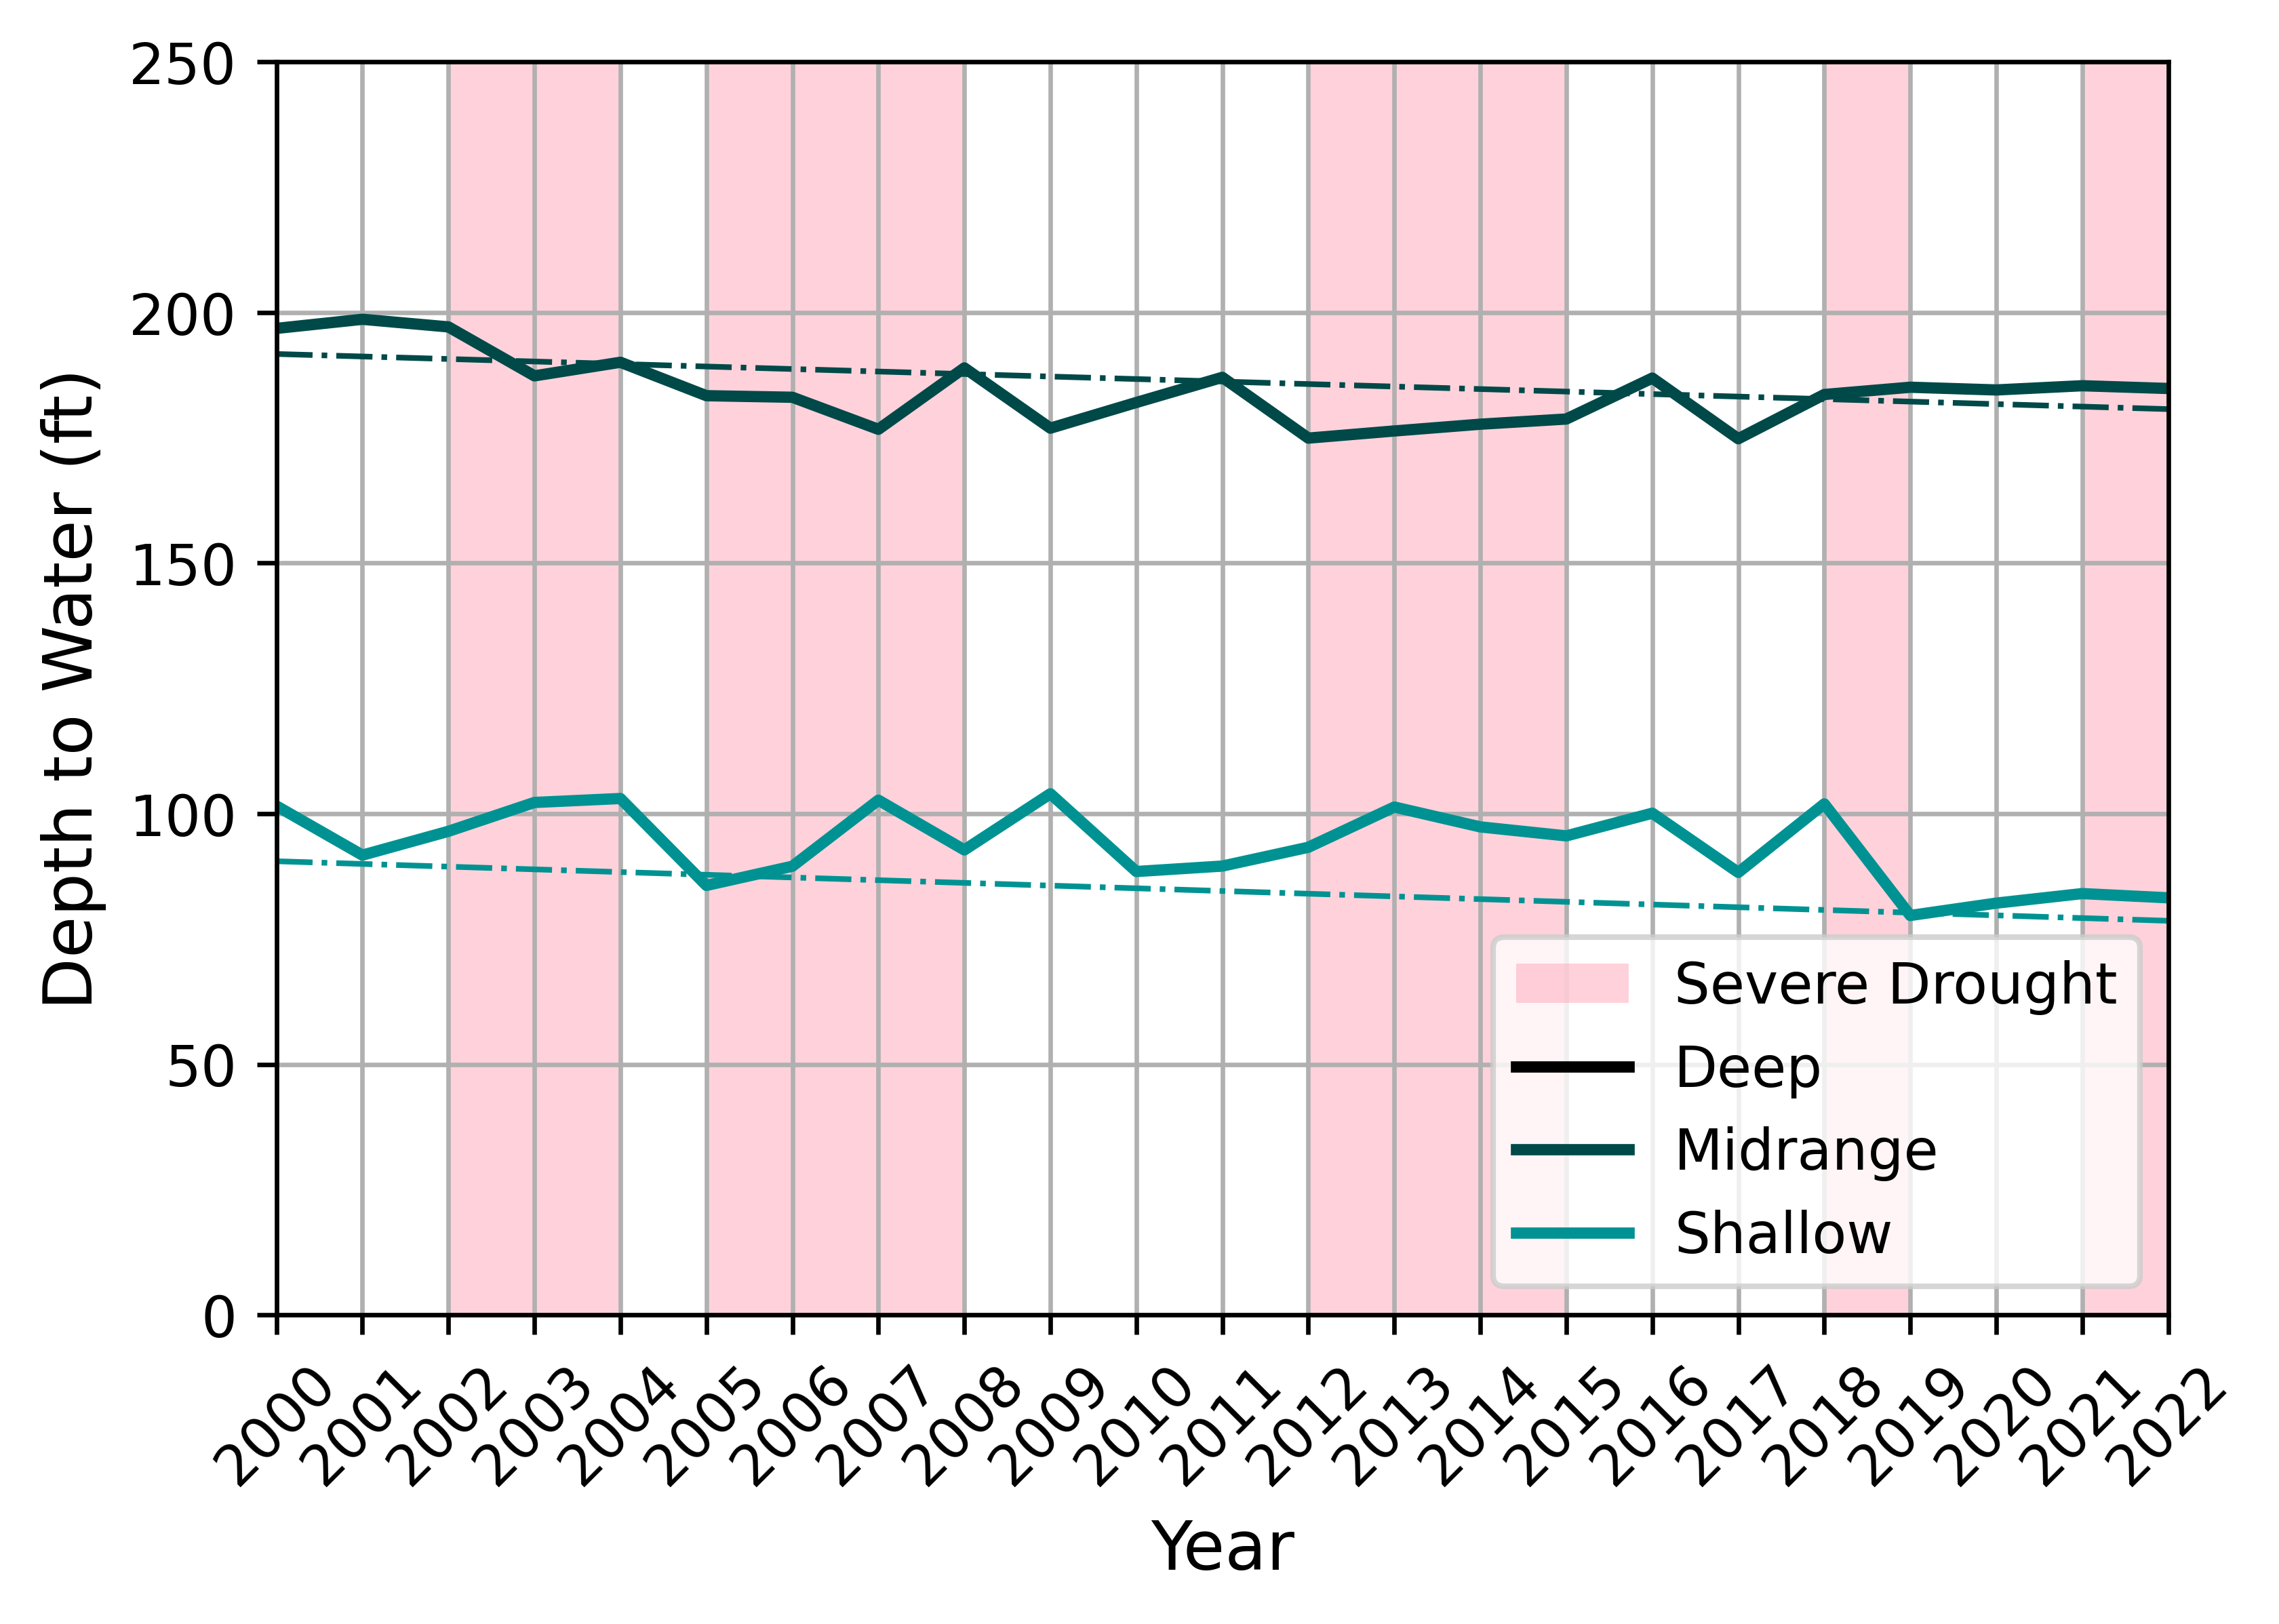

In [41]:
# For Depth to Water by regulation
# ds = wlanalysis_period
ds = df_interpolated
min_yr = 2000
mx_yr = 2022
Name = "mean_"+StudyArea

# betterlabels = [StudyArea]
# betterlabels = ['Control','GSF/USF','USF']

f = ds[(ds.index >= min_yr) & (ds.index <= mx_yr)]
columns = ds.columns
column_list = ds.columns.tolist()

betterlabels = column_list

stats = pd.DataFrame()
# for i in range(1, 12, 1):
for i in column_list:
        df = f[i]
        #print(df)
        y=np.array(df.values, dtype=float)
        x=np.array(pd.to_datetime(df).index.values, dtype=float)
        slope, intercept, r_value, p_value, std_err =sp.linregress(x,y)
        stats = stats._append({'slope': slope, 
                              'int':intercept, 
                              'rsq':r_value*r_value, 
                              'p_val':p_value, 
                              'std_err':std_err, 
                              'mean': np.mean(y),
                              'var': np.var(y),
                              'sum': np.sum(y)
                              },
                              ignore_index=True)


stats.index = betterlabels
stats1 = stats.transpose()
print(stats1)
stats1.to_csv(outputpath_local+'Stats_'+StudyArea+'.csv')

# -- Data visualization --
fig, ax = plt.subplots(1, 1, figsize = (6,4))

min_y = 0
max_y = 250
fsize = 12

num_years = mx_yr - min_yr + 1
ax.set_xticks(np.linspace(min_yr, mx_yr, num_years))
ax.set_xticklabels(map(int, ax.get_xticks()))

# Drought Year Shading
a = 1988
b = 1990
c = 1995
d = 1996
e = 2021
f = 2022
g = 2002
h = 2004
i = 2005
j = 2008
k = 2012
l = 2015
m = 2018
n = 2019
plt.axvspan(a, b, color=drought_color, alpha=0.5, lw=0
            , label="Severe Drought"
            )
plt.axvspan(c, d, color=drought_color, alpha=0.5, lw=0)
plt.axvspan(e, f, color=drought_color, alpha=0.5, lw=0)
plt.axvspan(g, h, color=drought_color, alpha=0.5, lw=0)
plt.axvspan(i, j, color=drought_color, alpha=0.5, lw=0)
plt.axvspan(k, l, color=drought_color, alpha=0.5, lw=0)
plt.axvspan(m, n, color=drought_color, alpha=0.5, lw=0)

# Plotting the data
for i,j in zip(stats1.columns,color_list):
        ax.plot(ds[i],color=j, label=str(i),lw=2)
# ax.plot(ds[column_list[0]], color=water_designation)
# ax.plot(ds[column_list[0]], color=blind[1],label=betterlabels[0]) 
# ax.plot(ds[column_list[1]], color=blind[2],label=betterlabels[1]) 
# ax.plot(ds[column_list[2]], color=blind[6],label=betterlabels[2])  
xf = np.linspace(min(x),max(x),100)
xf1 = xf.copy()

# Plotting Trendlines
for i,j in zip(stats1.columns,color_list):
        #xf1 = pd.to_datetime(xf1)
        m1 = round(stats1.loc['slope',i], 2)
        yint1 = round(stats1.loc['int',i], 2)
        pval1 = round(stats1.loc['p_val',i], 4)
        yf1 = (m1*xf)+yint1
        # ax.plot(xf1, yf1,"-.",color=blind[j], lw=1)
        ax.plot(xf1, yf1,"-.",color=j, lw=1)

ax.set_xlim(min_yr,mx_yr)
ax.set_ylim(min_y,max_y)
# ax.grid(True)
ax.grid(visible=True,which='major')
ax.grid(which='minor',color='#EEEEEE', lw=0.8)
ax.set_xlabel('Year', fontsize=fsize)
ax.set_ylabel('Depth to Water (ft)',fontsize=fsize)
# ax.minorticks_on()
ax.tick_params(axis='x', rotation=45)
fig.set_dpi(600.0)
# ax.set_title('a)',loc='left',pad=15)
ax.legend(loc='lower right')

# #Putting Grace on a secondary axis
# ax2 = ax.twinx()
# ax2.plot(grace_yearly['0'], label='State Average LWE', color='k',zorder=1)
# ax2.set_ylim([15, -15])
# ax2.set_ylabel(u'Δ LWE (cm)',fontsize=fsize)
# ax2.legend(loc='lower right')

plt.savefig(figurepath+Name, bbox_inches = 'tight')

In [103]:
# Anomaly's
# ds = wlanalysis_period.copy()
ds = df_interpolated.copy()
columns = ds.columns
column_list = ds.columns.tolist()
# trend_df = wlanalysis_period.copy()
trend_df = df_interpolated.copy()
dtw_anomalys = pd.DataFrame()
for i in column_list:
        # Subtracting against the mean
        # dtw_anomalys[i] = wlanalysis_period[i] - wlanalysis_period[i].mean()
        
        # Subtracting against the slope
        df = ds[i]
        y=np.array(df.values, dtype=float)
        x=np.array(pd.to_datetime(df).index.values, dtype=float)
        slope, intercept, r_value, p_value, std_err = sp.linregress(x,y)
        # print(y)
        # slope, intercept = sp.linregress(x,y) 
        # trend_df[i] = (wlanalysis_period.index*slope) + intercept
        # dtw_anomalys[i] = wlanalysis_period[i] - trend_df[i]
        trend_df[i] = (df_interpolated.index*slope) + intercept
        dtw_anomalys[i] = df_interpolated[i] - trend_df[i]
        

dtw_anomalys.head()

,YUMA
index,
2000,3.27
2001,22.17
2002,-5.85
2003,-5.12
2004,-4.68


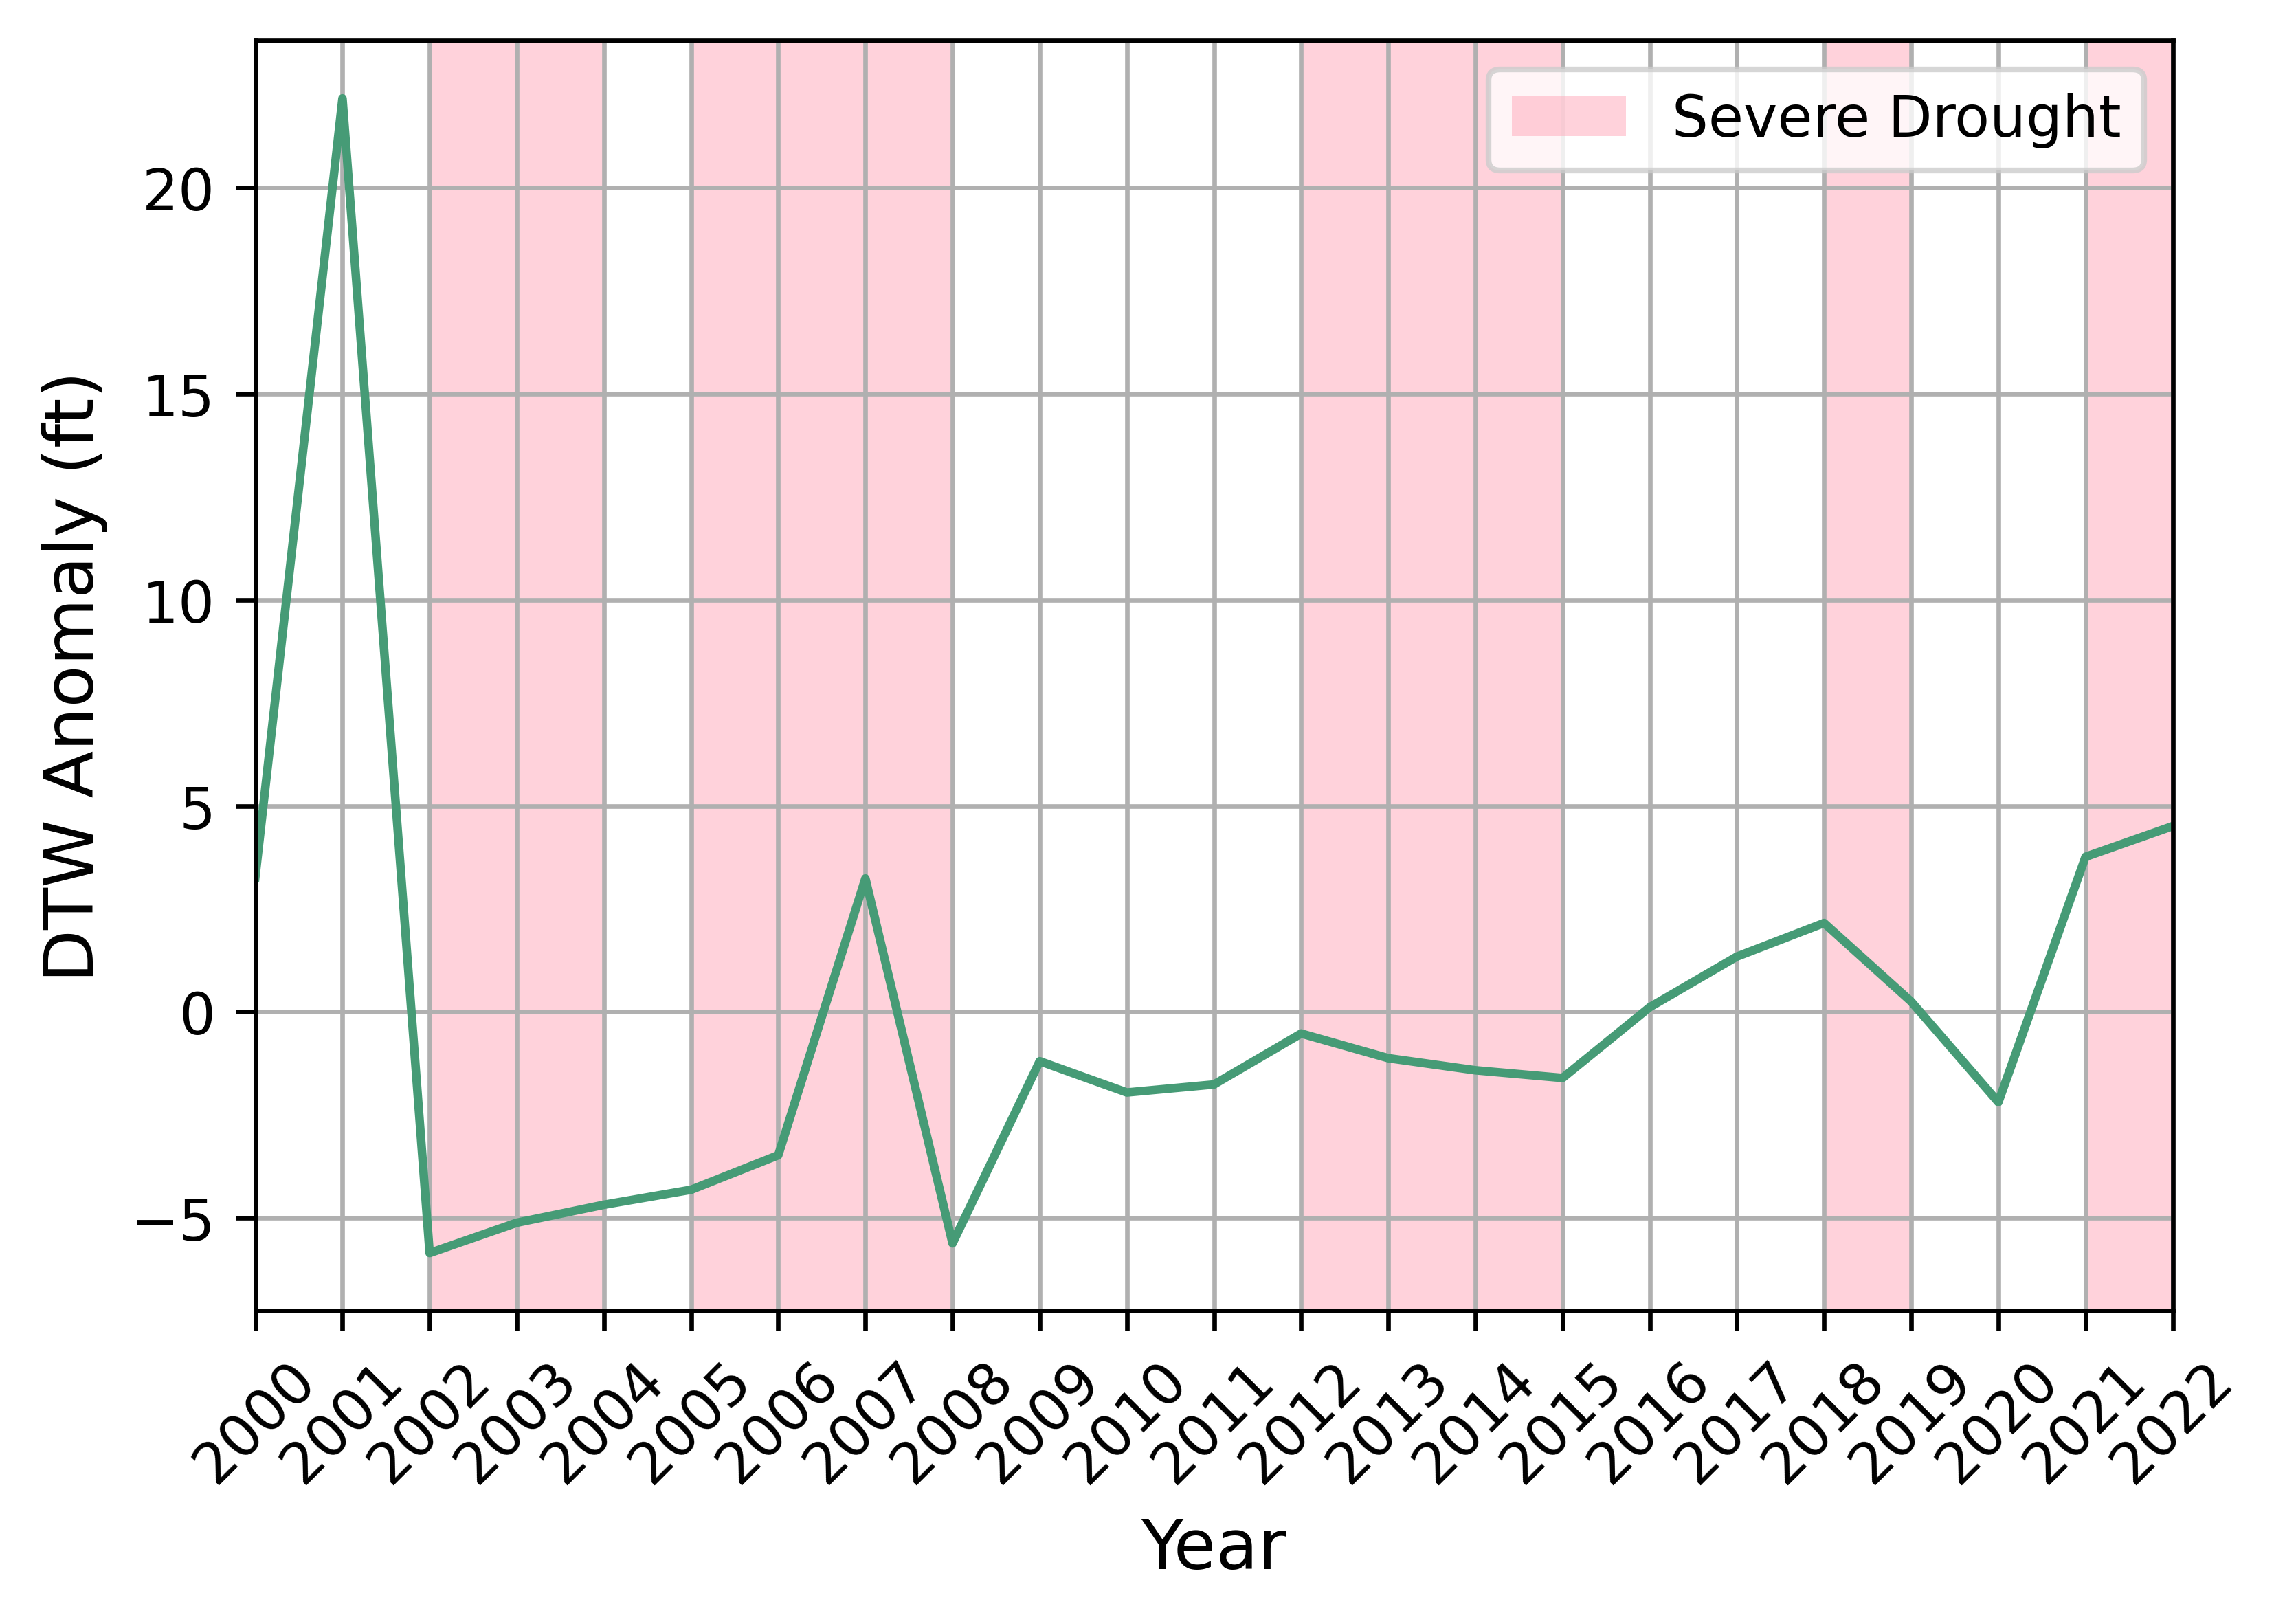

In [104]:
# For Depth to Water by regulation
ds = dtw_anomalys
min_yr = 2000
mx_yr = 2022

columns = ds.columns
column_list = ds.columns.tolist()

fig, ax = plt.subplots(1, 1, figsize = (6,4))

min_y = -12
max_y = 15
fsize = 12
num_years = mx_yr - min_yr + 1
ax.set_xticks(np.linspace(min_yr, mx_yr, num_years))
ax.set_xticklabels(map(int, ax.get_xticks()))

# Drought Year Shading
a = 1988
b = 1990
c = 1995
d = 1996
e = 2021
f = 2022
g = 2002
h = 2004
i = 2005
j = 2008
k = 2012
l = 2015
m = 2018
n = 2019
plt.axvspan(a, b, color=drought_color, alpha=0.5, lw=0, label="Severe Drought")
plt.axvspan(c, d, color=drought_color, alpha=0.5, lw=0)
plt.axvspan(e, f, color=drought_color, alpha=0.5, lw=0)
plt.axvspan(g, h, color=drought_color, alpha=0.5, lw=0)
plt.axvspan(i, j, color=drought_color, alpha=0.5, lw=0)
plt.axvspan(k, l, color=drought_color, alpha=0.5, lw=0)
plt.axvspan(m, n, color=drought_color, alpha=0.5, lw=0)

ax.plot(ds[column_list[0]], color=water_designation, lw=1.5)
# ax.plot(ds[column_list[0]], color=blind[1],label=betterlabels[0]) 
# ax.plot(ds[column_list[1]], color=blind[2],label=betterlabels[1]) 
# ax.plot(ds[column_list[2]], color=blind[6],label=betterlabels[2])  

ax.set_xlim(min_yr,mx_yr)
# ax.set_ylim(min_y,max_y)
# ax.grid(True)
ax.grid(visible=True,which='major')
ax.grid(which='minor',color='#EEEEEE', lw=0.8)
ax.set_xlabel('Year', fontsize=fsize)
ax.set_ylabel('DTW Anomaly (ft)',fontsize=fsize)
# ax.minorticks_on()
ax.tick_params(axis='x', rotation=45)
fig.set_dpi(600.0)
# ax.set_title('a)',loc='left',pad=15)
ax.legend(loc='upper right')

#Putting Grace on a secondary axis
# ax2 = ax.twinx()
# ax2.plot(grace_yearly['0'], label='State Average LWE', color='k',zorder=1)
# ax2.set_ylim([15, -15])
# ax2.set_ylabel(u'Δ LWE (cm)',fontsize=fsize)
# ax2.legend(loc='lower right')

plt.savefig(figurepath+'Timeseries of DTW Anomalies for '+StudyArea, bbox_inches = 'tight')

Calculating Max Drawdown (maximum anomaly in the drought period)

In [105]:
# %% Average Anomalie for drought periods
ds = dtw_anomalys.copy()
columns = ds.columns
column_list = ds.columns.tolist()

ds['Status'] = 'Normal-Wet'
# wlanalysis_period

for x,y in DROUGHT_YEARS.items():
        ds.loc[y, 'Status'] = 'Drought '+str(x)


dtw_max_anomalies = ds.groupby(['Status']).max()
dtw_max_anomalies
# ds

,YUMA
Status,
Drought 3,-5.12
Drought 4,3.24
Drought 5,-0.52
Drought 6,2.16
Drought 7,3.77
Normal-Wet,22.17


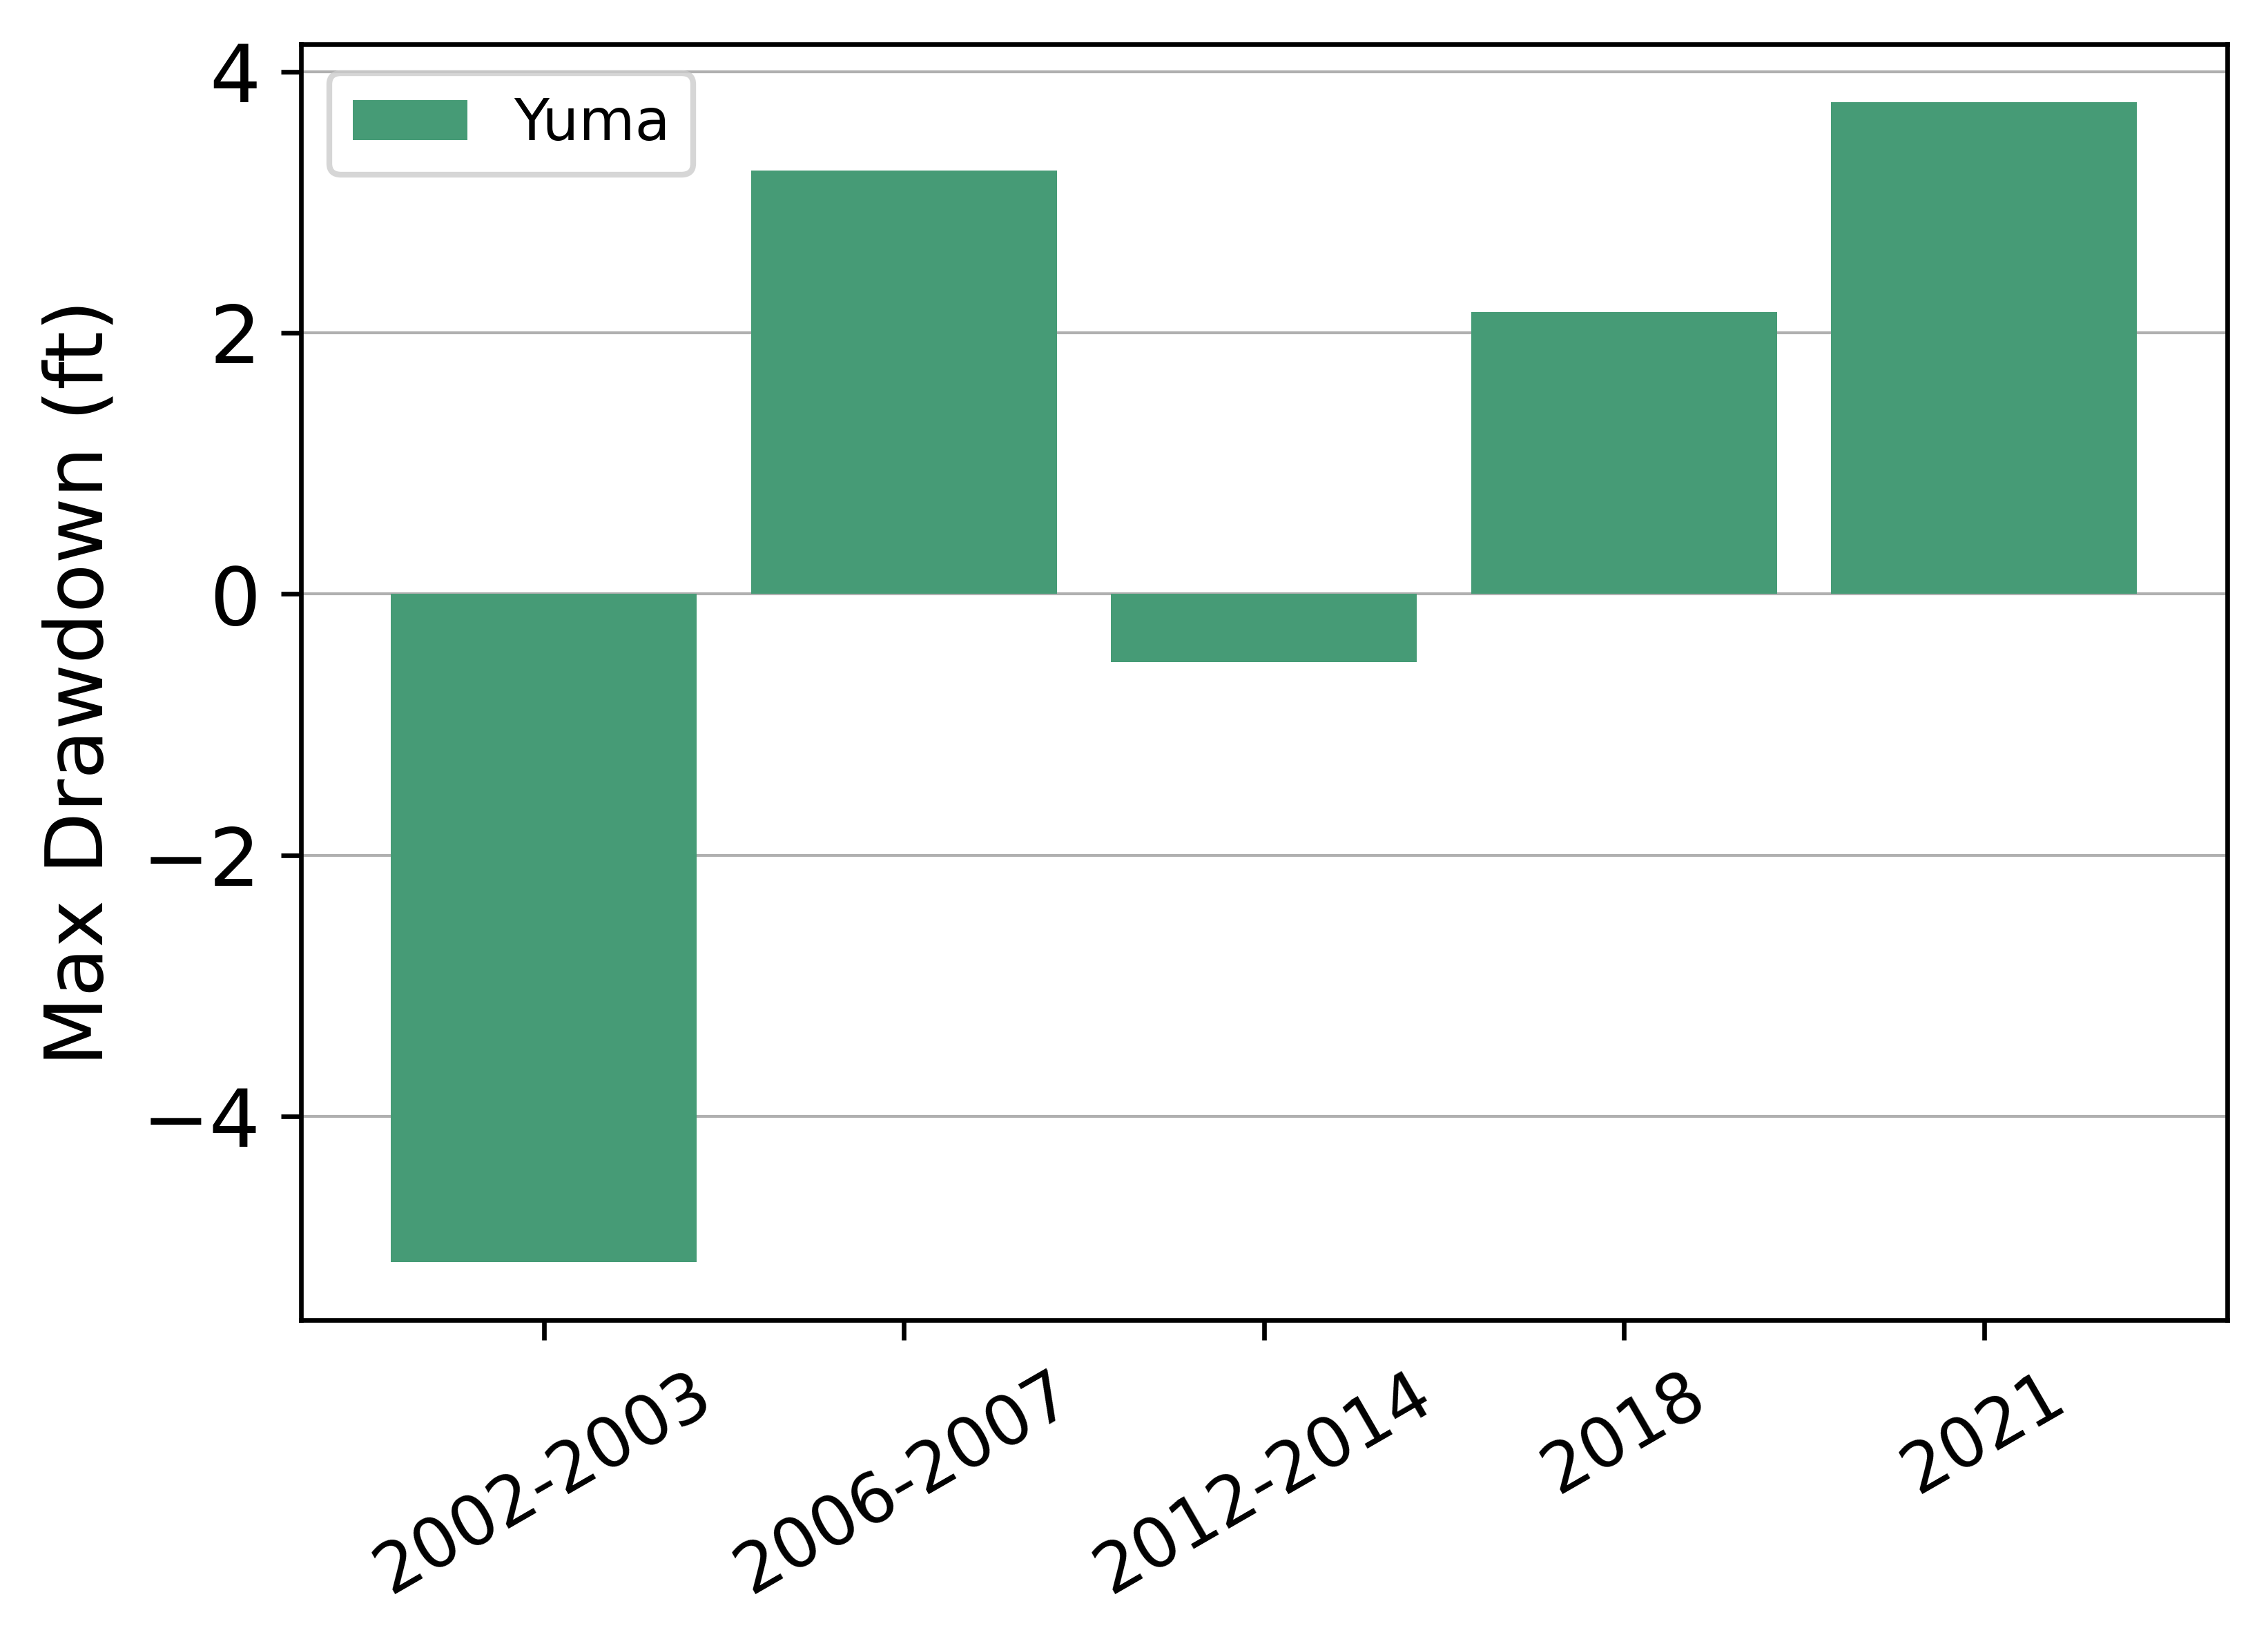

In [106]:
#%% Grouped Bar chart for drawdown (ft)
# name = 'Average DTW Anomalies by Drought Period and Groundwater Regulation'
name = 'Max Drawdown by Drought Period for '+StudyArea

yearlabels = [
                # "1989-1990"
        #       ,'1996',
              '2002-2003','2006-2007','2012-2014','2018','2021'
              ,'Normal/Wet Years'
        ]
# betterlabels = ['CAP','Regulated \n Groundwater','Surface \n Water','Unregulated \n Groundwater','Mixed \n GW/SW'] 
# betterlabels = [StudyArea]

dtw_max_anomalies.index = yearlabels
dtw_max_anomalies = dtw_max_anomalies.transpose()

dtw_max_anomalies.index = betterlabels
del dtw_max_anomalies['Normal/Wet Years']
dtw_max_anomalies = dtw_max_anomalies.transpose()

# group_colors = ['lightsalmon','tomato','orangered','r','brown','indianred','steelblue']

# group_colors = [blind[0],blind[2],blind[6]
#                 ,blind[12],blind[11],blind[10]
#                 # ,blind[0] #black
                # ]
group_colors = [water_designation]

horlabel = 'Max Drawdown (ft)'
fsize = 14

plt.rcParams["figure.dpi"] = 600
dtw_max_anomalies.plot(figsize = (6,4),
        kind='bar',
        stacked=False,
        # title=name,
        color = group_colors,
        zorder = 2,
        width = 0.85,
        fontsize = fsize
        )
# plt.title(name, fontsize = (fsize+2))
# plt.ylim([0,400])
plt.ylabel(horlabel, fontsize = fsize)
plt.xticks(rotation=30, fontsize = fsize-2)
plt.grid(axis='y', linewidth=0.5, zorder=0)
# plt.legend(loc=[1.01,0.3],fontsize = fsize)
# plt.set_dpi(600)

plt.savefig(figurepath+name+'_anomalies_groupedchart', bbox_inches = 'tight')

In [107]:
# New wells

static_geo2['INSTALLED'] = pd.to_datetime(static_geo2['INSTALLED'])
# static_geo2['INSTALLED'].describe()

static_geo2['In_year'] = static_geo2['INSTALLED'].dt.year
new_wells = pd.pivot_table(static_geo2, index=["In_year"], columns=[Naming_col+"_right"], values=["INSTALLED"], dropna=False, aggfunc=len)
# new_wells = pd.pivot_table(static_geo2, index=["In_year"], columns=[Naming_col], values=["INSTALLED"], dropna=False, aggfunc=len)
# new_wells = new_wells.reset_index()
new_wells.to_csv(outputpath_local+'Final_NewWells_'+StudyArea+'.csv')

In [108]:
# To get it formatted correctly

new_wells2 = pd.read_csv(outputpath_local+'Final_NewWells_'+StudyArea+'.csv',
                        header=2,
                        # names = ['R','Res','U']
                        names = betterlabels
                        # names = [StudyArea]
                        , index_col=0)
new_wells2

,Yuma
1930.00,1
1945.00,1
1946.00,1
1947.00,1
1951.00,2
...,...
2019.00,17
2020.00,40
2021.00,75
2022.00,32


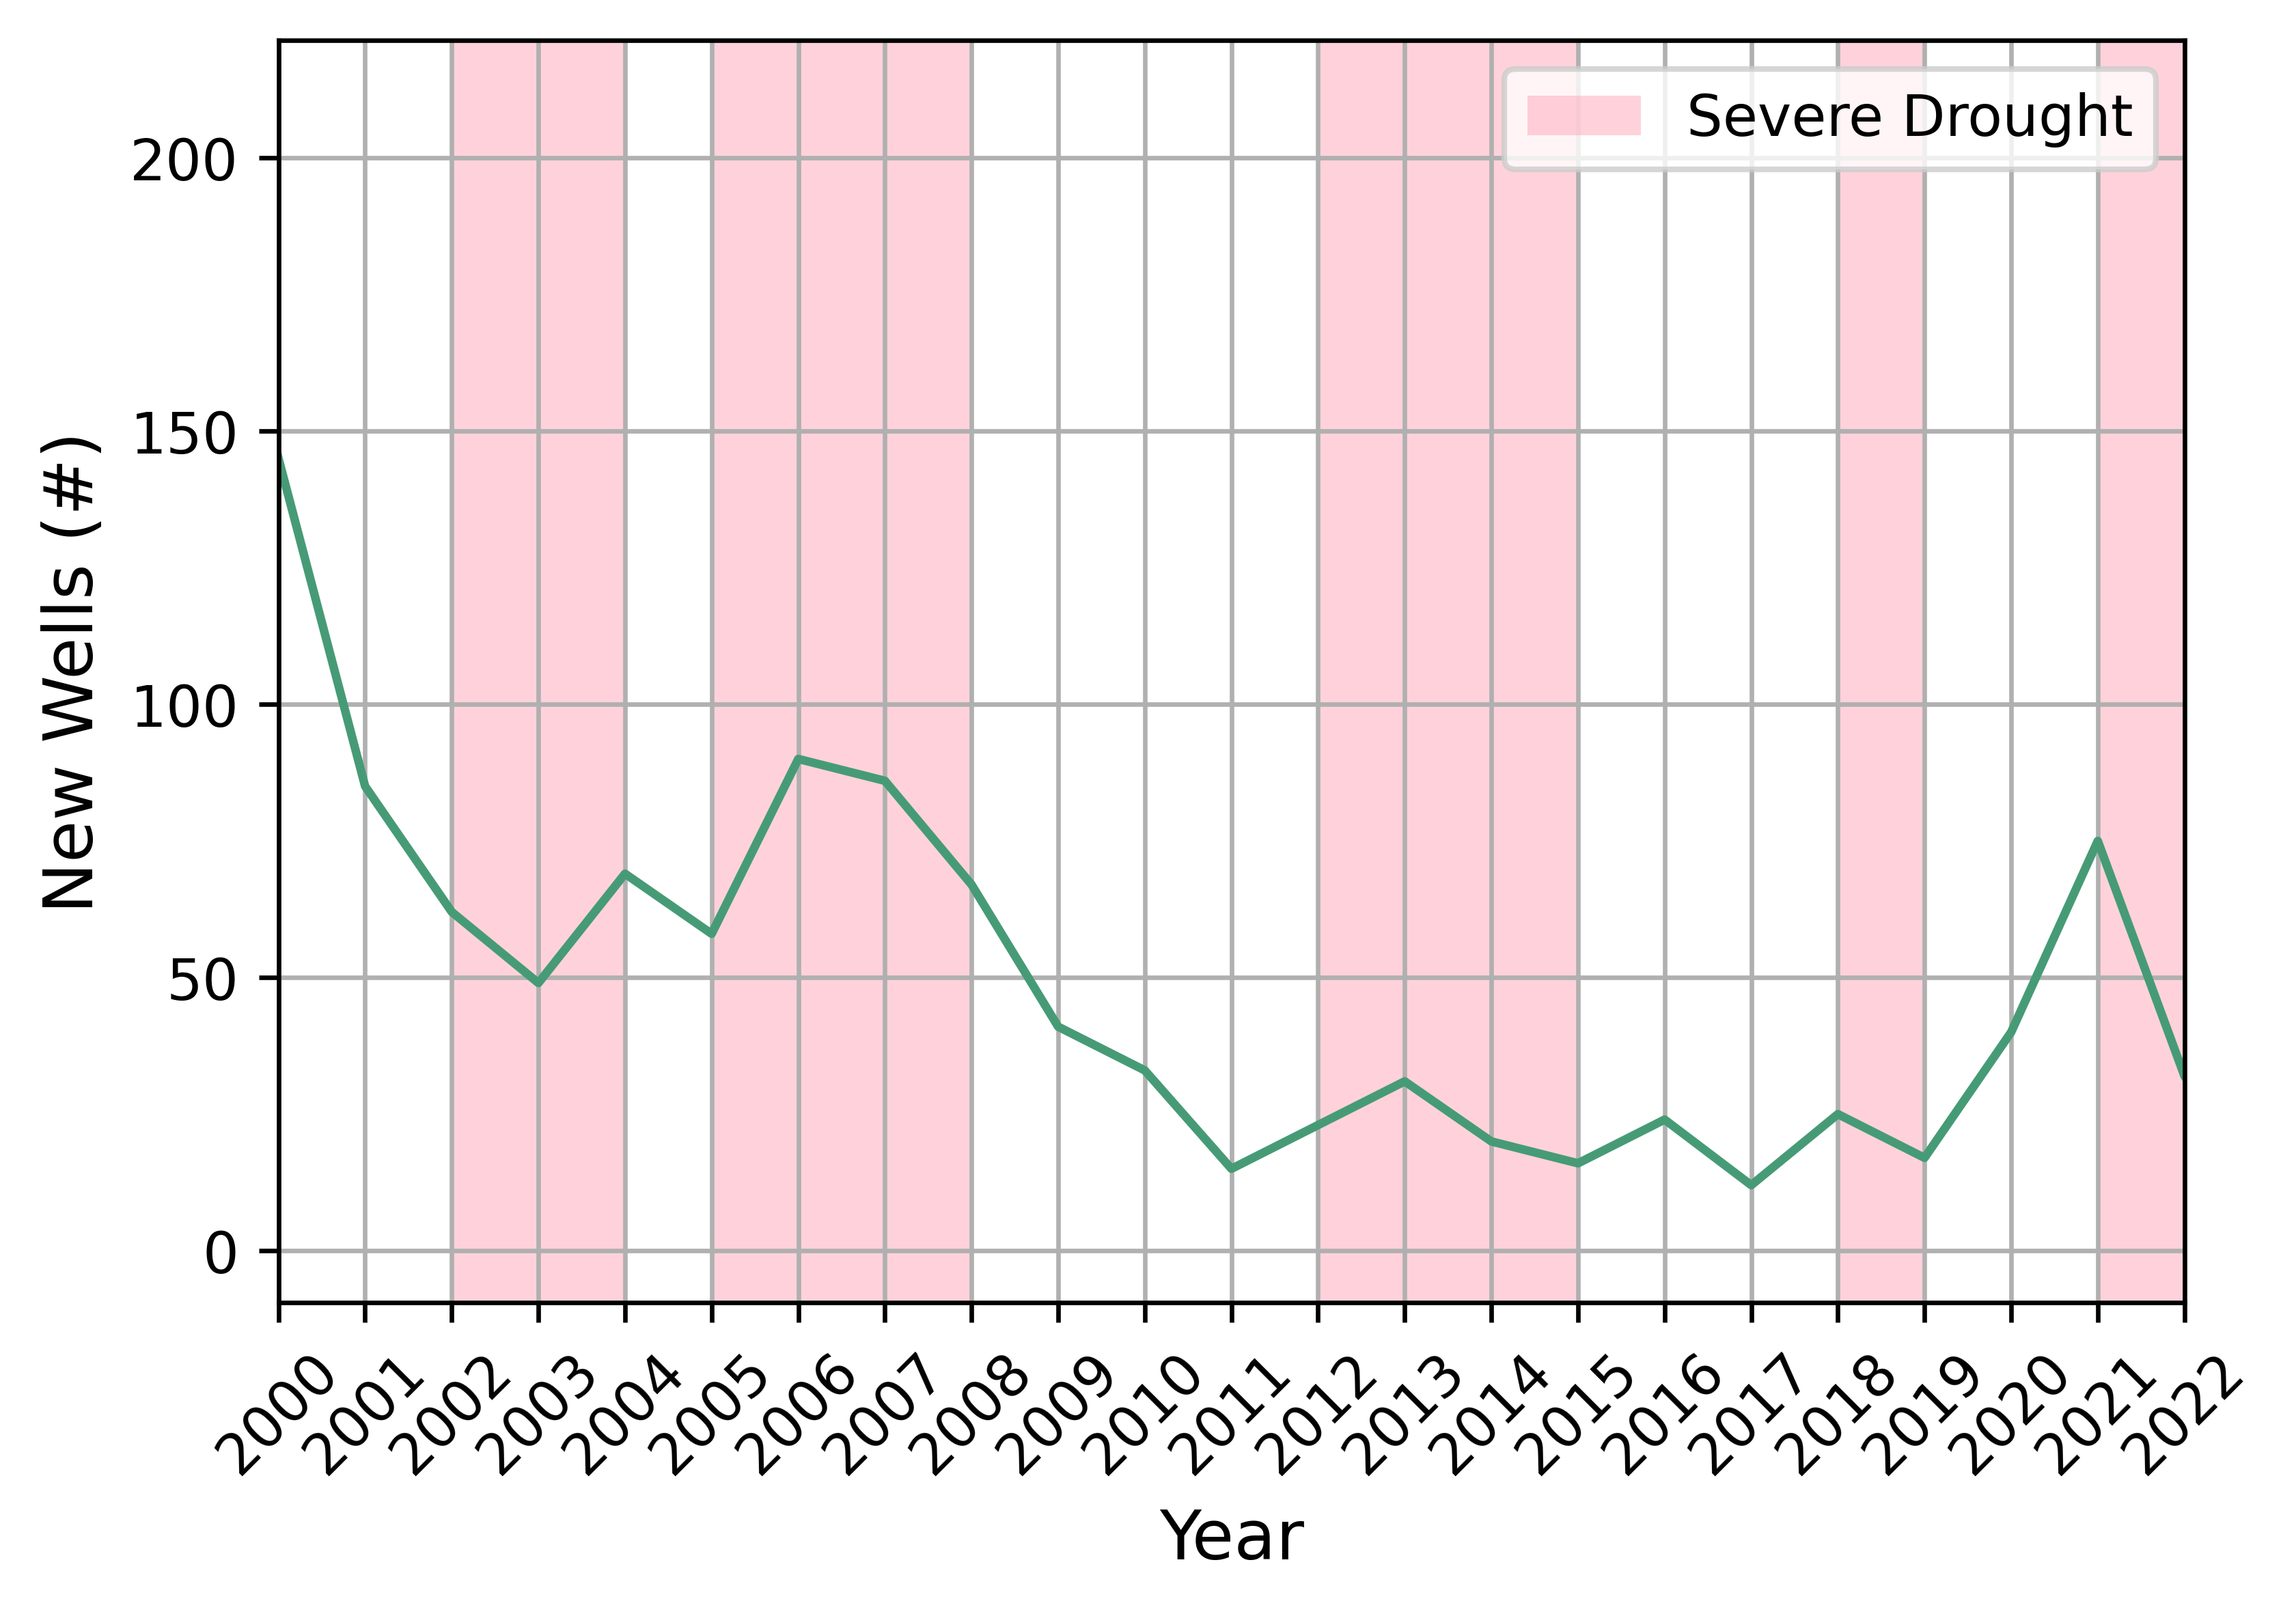

In [109]:

# For Depth to Water by regulation
ds = new_wells2
min_yr = 2000
mx_yr = 2022
# betterlabels = ['Regulated','Unregulated']

columns = ds.columns
column_list = ds.columns.tolist()

fig, ax = plt.subplots(1, 1, figsize = (6,4))

min_y = -12
max_y = 15
fsize = 12
num_years = mx_yr - min_yr + 1
ax.set_xticks(np.linspace(min_yr, mx_yr, num_years))
ax.set_xticklabels(map(int, ax.get_xticks()))

# Drought Year Shading
a = 1988
b = 1990
c = 1995
d = 1996
e = 2021
f = 2022
g = 2002
h = 2004
i = 2005
j = 2008
k = 2012
l = 2015
m = 2018
n = 2019
plt.axvspan(a, b, color=drought_color, alpha=0.5, lw=0, label="Severe Drought")
plt.axvspan(c, d, color=drought_color, alpha=0.5, lw=0)
plt.axvspan(e, f, color=drought_color, alpha=0.5, lw=0)
plt.axvspan(g, h, color=drought_color, alpha=0.5, lw=0)
plt.axvspan(i, j, color=drought_color, alpha=0.5, lw=0)
plt.axvspan(k, l, color=drought_color, alpha=0.5, lw=0)
plt.axvspan(m, n, color=drought_color, alpha=0.5, lw=0)

ax.plot(ds[column_list[0]], color=water_designation, lw=1.5) 
# ax.plot(ds[column_list[0]], color=blind[1],label=betterlabels[0]) 
# ax.plot(ds[column_list[1]], color=blind[2],label=betterlabels[1]) 
# ax.plot(ds[column_list[2]], color=blind[6],label=betterlabels[2])  

ax.set_xlim(min_yr,mx_yr)
# ax.set_ylim(min_y,max_y)
# ax.grid(True)
ax.grid(visible=True,which='major')
ax.grid(which='minor',color='#EEEEEE', lw=0.8)
ax.set_xlabel('Year', fontsize=fsize)
ax.tick_params(axis='x', rotation=45)
ax.set_ylabel('New Wells (#)',fontsize=fsize)
# ax.minorticks_on()
fig.set_dpi(600.0)
# ax.set_title('a)',loc='left',pad=15)
ax.legend(loc='upper right')

#Putting Grace on a secondary axis
# ax2 = ax.twinx()
# ax2.plot(grace_yearly['0'], label='State Average LWE', color='k',zorder=1)
# ax2.set_ylim([15, -15])
# ax2.set_ylabel(u'Δ LWE (cm)',fontsize=fsize)
# ax2.legend(loc='lower right')

plt.savefig(figurepath+'Timeseries of New Wells for '+StudyArea, bbox_inches = 'tight')